In [17]:
!pip install -r C:\Users\TaeyoonKim\50-ML-Challenge\case_study_2\requirements.txt

In [18]:
from sklearn.datasets import fetch_openml
X_orig, y = fetch_openml(data_id=43874, as_frame=True, return_X_y=True)

The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.


In [19]:
X_orig.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 24 columns):
 #   Column                    Non-Null Count   Dtype   
---  ------                    --------------   -----   
 0   race                      101766 non-null  object  
 1   gender                    101766 non-null  object  
 2   age                       101766 non-null  object  
 3   discharge_disposition_id  101766 non-null  object  
 4   admission_source_id       101766 non-null  object  
 5   time_in_hospital          101766 non-null  int64   
 6   medical_specialty         101766 non-null  object  
 7   num_lab_procedures        101766 non-null  int64   
 8   num_procedures            101766 non-null  int64   
 9   num_medications           101766 non-null  int64   
 10  primary_diagnosis         101766 non-null  object  
 11  number_diagnoses          101766 non-null  int64   
 12  max_glu_serum             101766 non-null  object  
 13  A1Cresult                 101

In [20]:
# Check each row with columns 
X_orig.sample(n=5)

,race,gender,age,discharge_disposition_id,admission_source_id,time_in_hospital,medical_specialty,num_lab_procedures,num_procedures,num_medications,primary_diagnosis,number_diagnoses,max_glu_serum,A1Cresult,insulin,change,diabetesMed,medicare,medicaid,had_emergency,had_inpatient_days,had_outpatient_days,readmitted,readmit_binary
88842,Caucasian,Female,30-60 years,Discharged to Home,Emergency,1,Missing,4,0,9,Other,9,None,None,No,No,Yes,False,False,True,True,True,NO,0
91140,Caucasian,Female,Over 60 years,Discharged to Home,Referral,8,Missing,22,2,33,Other,9,None,None,No,No,No,False,False,False,False,False,NO,0
59550,Caucasian,Male,Over 60 years,Other,Referral,2,Missing,25,1,13,Other,6,None,None,No,No,No,False,False,False,False,True,NO,0
99516,Other,Male,Over 60 years,Discharged to Home,Referral,6,Missing,71,3,27,Other,9,None,None,Up,Ch,Yes,True,False,False,False,False,NO,0
74151,Caucasian,Female,30-60 years,Other,Referral,6,Missing,40,1,13,Other,9,None,None,Up,Ch,Yes,True,False,True,True,False,NO,0


In [21]:
!pip install raiwidgets lightgbm optuna shap --quiet

In [22]:
import math
import os
import numpy as np
import pandas as pd

pd.set_option('display.max_columns',50)
pd.set_option('display.max_rows',50)  


from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn import metrics

import lightgbm as lgb
import optuna

from responsibleai import RAIInsights
from raiwidgets import ResponsibleAIDashboard
# from raiwidgets.cohort import Cohort, CohortFilter, CohortFilterMethods
import shap

from IPython.display import Markdown, display
import matplotlib.pyplot as plt
import seaborn as sns

In [23]:
X_orig['readmitted'].value_counts()

NO     54864
>30    35545
<30    11357
Name: readmitted, dtype: int64

In [24]:
X_orig['readmit_binary'].value_counts()

0    54864
1    46902
Name: readmit_binary, dtype: int64

In [25]:
y.value_counts()

0    90409
1    11357
Name: readmit_30_days, dtype: int64

In [26]:
#인코딩을 위한 함수 정의
def transform_data(X_):
    #Remove alternative target columns
    X = X_.drop(['readmitted', 'readmit_binary'], axis=1)

    #Binary encode boolean columns
    bool_cols_l = X.select_dtypes(include=["category"]).columns.tolist()
    X[bool_cols_l] = X[bool_cols_l].astype(str).replace({"True":1, "False":0})
    print(bool_cols_l)

    #One hot encode categorical columns
    cat_cols_l = X.select_dtypes(include=["object"]).columns.tolist()
    print(cat_cols_l)
    ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)
    ohe_np = ohe.fit_transform(X[cat_cols_l].astype("category"))
    X[ohe.get_feature_names_out(cat_cols_l)] = ohe_np.astype(int)

    #Drop original categorical columns
    X.drop(cat_cols_l, axis=1, inplace=True)

    return X

In [27]:
X = transform_data(X_orig)

['medicare', 'medicaid', 'had_emergency', 'had_inpatient_days', 'had_outpatient_days']
['race', 'gender', 'age', 'discharge_disposition_id', 'admission_source_id', 'medical_specialty', 'primary_diagnosis', 'max_glu_serum', 'A1Cresult', 'insulin', 'change', 'diabetesMed']


`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.


In [28]:
print(f"Number of Features: {len(X_orig.columns)}")
print(X_orig.columns)

Number of Features: 24
Index(['race', 'gender', 'age', 'discharge_disposition_id',
       'admission_source_id', 'time_in_hospital', 'medical_specialty',
       'num_lab_procedures', 'num_procedures', 'num_medications',
       'primary_diagnosis', 'number_diagnoses', 'max_glu_serum', 'A1Cresult',
       'insulin', 'change', 'diabetesMed', 'medicare', 'medicaid',
       'had_emergency', 'had_inpatient_days', 'had_outpatient_days',
       'readmitted', 'readmit_binary'],
      dtype='object')


In [29]:
print(f"Number of Features(After processing): {len(X.columns)}")
print(X.columns)

Number of Features(After processing): 54
Index(['time_in_hospital', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_diagnoses', 'medicare', 'medicaid',
       'had_emergency', 'had_inpatient_days', 'had_outpatient_days',
       'race_AfricanAmerican', 'race_Asian', 'race_Caucasian', 'race_Hispanic',
       'race_Other', 'race_Unknown', 'gender_Female', 'gender_Male',
       'gender_Unknown/Invalid', 'age_30 years or younger', 'age_30-60 years',
       'age_Over 60 years', 'discharge_disposition_id_Discharged to Home',
       'discharge_disposition_id_Other', 'admission_source_id_Emergency',
       'admission_source_id_Other', 'admission_source_id_Referral',
       'medical_specialty_Cardiology', 'medical_specialty_Emergency/Trauma',
       'medical_specialty_Family/GeneralPractice',
       'medical_specialty_InternalMedicine', 'medical_specialty_Missing',
       'medical_specialty_Other', 'primary_diagnosis_Diabetes',
       'primary_diagnosis_Genitourinary Is

In [30]:
rand = 42
os.environ['PYTHONHASHSEED']=str(rand)
np.random.seed(rand)

In [31]:
classes_l = ['NO or > 30 days', '< 30 days']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=rand)
X_orig_test = X_orig.loc[X_test.index]

In [32]:
X_train

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_diagnoses,medicare,medicaid,had_emergency,had_inpatient_days,had_outpatient_days,race_AfricanAmerican,race_Asian,race_Caucasian,race_Hispanic,race_Other,race_Unknown,gender_Female,gender_Male,gender_Unknown/Invalid,age_30 years or younger,age_30-60 years,age_Over 60 years,discharge_disposition_id_Discharged to Home,discharge_disposition_id_Other,admission_source_id_Emergency,...,medical_specialty_Family/GeneralPractice,medical_specialty_InternalMedicine,medical_specialty_Missing,medical_specialty_Other,primary_diagnosis_Diabetes,primary_diagnosis_Genitourinary Issues,primary_diagnosis_Musculoskeletal Issues,primary_diagnosis_Other,primary_diagnosis_Respiratory Issues,max_glu_serum_>200,max_glu_serum_>300,max_glu_serum_None,max_glu_serum_Norm,A1Cresult_>7,A1Cresult_>8,A1Cresult_None,A1Cresult_Norm,insulin_Down,insulin_No,insulin_Steady,insulin_Up,change_Ch,change_No,diabetesMed_No,diabetesMed_Yes
15992,10,45,0,14,9,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,1,0,1,...,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1
10606,4,39,0,11,5,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,1,0,1,...,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,1,0
64779,1,37,2,7,5,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,1,0,0,...,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,1,0
83257,8,45,0,24,9,1,0,1,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,1,1,...,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,1
4204,12,51,0,12,7,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,1,1,...,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6265,2,35,0,12,9,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,1,0,1,...,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,1,1,0
54886,5,63,2,23,9,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,1,0,0,...,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,1,0,0,1
76820,3,55,1,33,9,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,...,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,1
860,12,77,2,21,9,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,1,1,...,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,1


In [33]:
X_test

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_diagnoses,medicare,medicaid,had_emergency,had_inpatient_days,had_outpatient_days,race_AfricanAmerican,race_Asian,race_Caucasian,race_Hispanic,race_Other,race_Unknown,gender_Female,gender_Male,gender_Unknown/Invalid,age_30 years or younger,age_30-60 years,age_Over 60 years,discharge_disposition_id_Discharged to Home,discharge_disposition_id_Other,admission_source_id_Emergency,...,medical_specialty_Family/GeneralPractice,medical_specialty_InternalMedicine,medical_specialty_Missing,medical_specialty_Other,primary_diagnosis_Diabetes,primary_diagnosis_Genitourinary Issues,primary_diagnosis_Musculoskeletal Issues,primary_diagnosis_Other,primary_diagnosis_Respiratory Issues,max_glu_serum_>200,max_glu_serum_>300,max_glu_serum_None,max_glu_serum_Norm,A1Cresult_>7,A1Cresult_>8,A1Cresult_None,A1Cresult_Norm,insulin_Down,insulin_No,insulin_Steady,insulin_Up,change_Ch,change_No,diabetesMed_No,diabetesMed_Yes
35956,11,68,0,20,5,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,1,0,0,...,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,1
60927,1,20,0,7,8,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,1,0,0,...,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,1
79920,4,21,3,23,7,0,0,0,1,1,0,0,1,0,0,0,1,0,0,0,0,1,0,1,0,...,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,1
50078,12,28,0,19,7,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,1,0,0,...,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,1
44080,1,21,0,6,7,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,1,1,...,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19901,1,45,1,5,4,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,1,0,1,...,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,1,0
9561,4,58,0,10,9,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,1,0,1,...,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,1
47211,2,68,6,16,9,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,1,0,1,...,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,1,0
25232,6,61,2,7,5,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,1,0,0,...,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,1,1,0


In [34]:
def evaluate_class_mdl(fitted_model, X_train, X_test, y_train, y_test, plot=True, pct=True, thresh=0.5):
    y_train_pred = fitted_model.predict(X_train).squeeze()
    if len(np.unique(y_train_pred)) > 2:
        y_train_pred = np.where(y_train_pred > thresh, 1, 0)
        y_test_prob = fitted_model.predict(X_test).squeeze()
        y_test_pred = np.where(y_test_prob > thresh, 1, 0)
    else:   
        y_test_prob = fitted_model.predict_proba(X_test)[:,1]
        y_test_pred = np.where(y_test_prob > thresh, 1, 0)
    roc_auc_te = metrics.roc_auc_score(y_test, y_test_prob)

    cf_matrix = metrics.confusion_matrix(y_test, y_test_pred)
    tn, fp, fn, tp = cf_matrix.ravel()
    acc_tr = metrics.accuracy_score(y_train, y_train_pred)
    acc_te = metrics.accuracy_score(y_test, y_test_pred)
    pre_te = metrics.precision_score(y_test, y_test_pred)
    rec_te = metrics.recall_score(y_test, y_test_pred)
    f1_te = metrics.f1_score(y_test, y_test_pred)
    mcc_te = metrics.matthews_corrcoef(y_test, y_test_pred)

    if plot:
        print(f"Accuracy_train:  {acc_tr:.4f}\t\tAccuracy_test:   {acc_te:.4f}")
        print(f"Precision_test:  {pre_te:.4f}\t\tRecall_test:     {rec_te:.4f}")
        print(f"ROC-AUC_test:    {roc_auc_te:.4f}\t\tF1_test:         {f1_te:.4f}\t\tMCC_test: {mcc_te:.4f}")
        plt.figure(figsize=(6, 5))
        if pct:
            ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True,\
                        fmt='.2%', cmap='Blues', annot_kws={'size':16})
        else:
            ax = sns.heatmap(cf_matrix, annot=True,\
                        fmt='d',cmap='Blues', annot_kws={'size':16})
        ax.set_xlabel('Predicted', fontsize=12)
        ax.set_ylabel('Observed', fontsize=12)
        plt.show()

        return y_train_pred, y_test_prob, y_test_pred
    else:
        t = cf_matrix.sum()
        metrics_dict = {'accuracy_train':acc_tr , 'accuracy_test':acc_te, 'precision':pre_te, 'recall':rec_te,\
                      'roc_auc':roc_auc_te,  'f1':f1_te, 'mcc': mcc_te, 'tn%':tn/t, 'fp%':fp/t, 'fn%':fn/t, 'tp%':tp/t }
        return metrics_dict

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003835 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start training from score -2.077043
Accuracy_train:  0.8888		Accuracy_test:   0.8877
Precision_test:  0.0000		Recall_test:     0.0000
ROC-AUC_test:    0.6469		F1_test:         0.0000		MCC_test: -0.0029


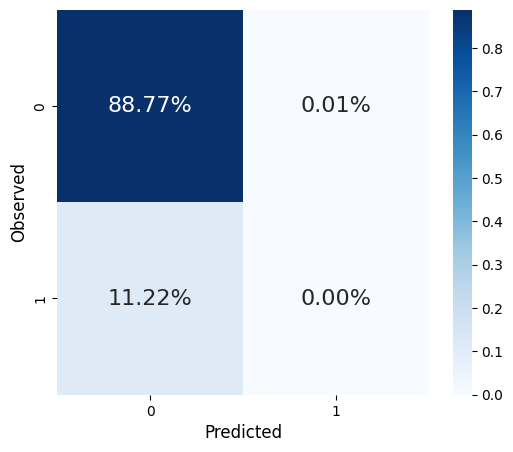

In [35]:
%matplotlib inline
clf = lgb.LGBMClassifier(random_state=rand, n_jobs=-1)
clf.fit(X_train, y_train)

_ =  evaluate_class_mdl(clf, X_train, X_test, y_train, y_test)

In [36]:
def_scale_pos_weight = len(y[y==0]) / len(y[y==1])
print(f"default scale pos weight: {def_scale_pos_weight:.2f}")

default scale pos weight: 7.96


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003128 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start training from score -2.077043
Accuracy_train:  0.6381		Accuracy_test:   0.6086
Precision_test:  0.1638		Recall_test:     0.6064
ROC-AUC_test:    0.6458		F1_test:         0.2580		MCC_test: 0.1379


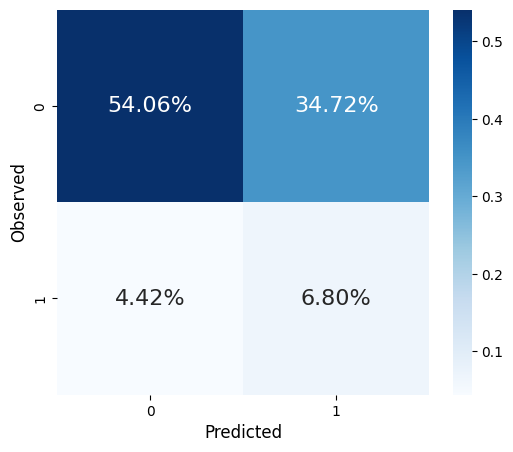

In [37]:
clf = lgb.LGBMClassifier(random_state=rand, n_jobs=-1, scale_pos_weight=def_scale_pos_weight)
clf.fit(X_train, y_train)
_ =  evaluate_class_mdl(clf, X_train, X_test, y_train, y_test)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003185 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start training from score -2.077043
Accuracy_train:  0.3354		Accuracy_test:   0.3157
Precision_test:  0.1293		Recall_test:     0.8893
ROC-AUC_test:    0.6438		F1_test:         0.2258		MCC_test: 0.0997


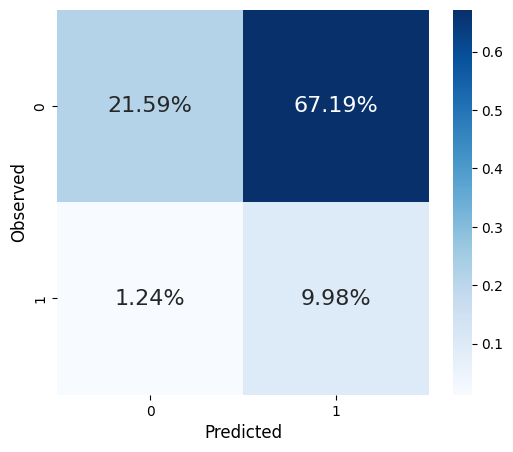

In [38]:
clf = lgb.LGBMClassifier(random_state=rand, n_jobs=-1, scale_pos_weight=def_scale_pos_weight*2)
clf.fit(X_train, y_train)

_ = evaluate_class_mdl(clf, X_train, X_test, y_train, y_test)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003254 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start training from score -2.077043
Accuracy_train:  0.8771		Accuracy_test:   0.8617
Precision_test:  0.2232		Recall_test:     0.0937
ROC-AUC_test:    0.6485		F1_test:         0.1320		MCC_test: 0.0782


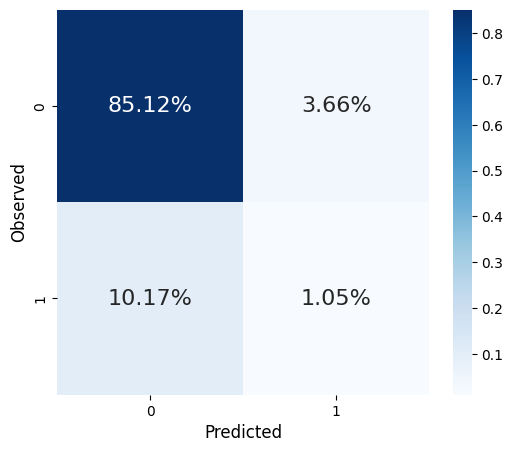

In [39]:
clf = lgb.LGBMClassifier(random_state=rand, n_jobs=-1, scale_pos_weight=def_scale_pos_weight/2)
clf.fit(X_train, y_train)

_ = evaluate_class_mdl(clf, X_train, X_test, y_train, y_test)

In [40]:
min_tn = X_orig[X_orig['readmitted']=='NO'].shape[0] / X_orig.shape[0]
print(f"Patients % that never readmitted (Minimum % of True Negatives): {min_tn:.2%}")

Patients % that never readmitted (Minimum % of True Negatives): 53.91%


In [41]:
max_fp = X_orig[X_orig['readmitted']=='>30'].shape[0] / X_orig.shape[0]
print(f"Patients % that were readmitted over 30 days later (Maximum % of False Positives): {max_fp:.2%}")

Patients % that were readmitted over 30 days later (Maximum % of False Positives): 34.93%


In [42]:
def optimize_lgb(trial): 
    params = {
        'max_depth': trial.suggest_int('max_depth', 2, 11),
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', def_scale_pos_weight/2, def_scale_pos_weight*2),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True)
    }
    if params['max_depth'] == 11:
        params['max_depth'] = -1

    clf = lgb.LGBMClassifier(random_state=rand, n_jobs=-1, **params)
    clf.fit(X_train, y_train)

    metrics_dict = evaluate_class_mdl(clf, X_train, X_test, y_train, y_test, plot=False)

    if (metrics_dict['tn%'] < min_tn) or (metrics_dict['fp%'] > max_fp):
        return 0

    return metrics_dict['recall']

In [ ]:
%%time
opt_study = optuna.create_study(direction='maximize')
opt_study.optimize(optimize_lgb, n_trials=10)

[I 2025-02-28 14:54:43,383] A new study created in memory with name: no-name-f6108286-4847-40cb-9ad7-849364af1222


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004430 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start training from score -2.077043
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[I 2025-02-28 14:54:43,706] Trial 0 finished with value: 0.1816058394160584 and parameters: {'max_depth': 5, 'scale_pos_weight': 4.558190577685794, 'reg_lambda': 0.003905448598080827, 'reg_alpha': 0.22354977234493503}. Best is trial 0 with value: 0.1816058394160584.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003457 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start training from score -2.077043
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[I 2025-02-28 14:54:44,067] Trial 1 finished with value: 0.5395620437956204 and parameters: {'max_depth': 7, 'scale_pos_weight': 7.131358606782102, 'reg_lambda': 1.352971931386978, 'reg_alpha': 1.0409921250820169e-07}. Best is trial 1 with value: 0.5395620437956204.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003844 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start training from score -2.077043


[I 2025-02-28 14:54:44,423] Trial 2 finished with value: 0.0 and parameters: {'max_depth': 11, 'scale_pos_weight': 8.1874659852223, 'reg_lambda': 2.9607508071224354e-05, 'reg_alpha': 2.812697387664478e-06}. Best is trial 1 with value: 0.5395620437956204.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003516 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start training from score -2.077043
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2025-02-28 14:54:44,751] Trial 3 finished with value: 0.0 and parameters: {'max_depth': 8, 'scale_pos_weight': 11.342506110385834, 'reg_lambda': 0.5962868082021267, 'reg_alpha': 0.013819443389109091}. Best is trial 1 with value: 0.5395620437956204.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003174 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start training from score -2.077043
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2025-02-28 14:54:45,088] Trial 4 finished with value: 0.0 and parameters: {'max_depth': 8, 'scale_pos_weight': 10.916026922458151, 'reg_lambda': 0.018684193852673378, 'reg_alpha': 8.441049434516582e-06}. Best is trial 1 with value: 0.5395620437956204.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002565 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start training from score -2.077043
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[I 2025-02-28 14:54:45,399] Trial 5 finished with value: 0.0 and parameters: {'max_depth': 5, 'scale_pos_weight': 14.426830475965676, 'reg_lambda': 0.0005664369150774068, 'reg_alpha': 0.24185226649597955}. Best is trial 1 with value: 0.5395620437956204.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003607 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start training from score -2.077043
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[I 2025-02-28 14:54:45,702] Trial 6 finished with value: 0.0 and parameters: {'max_depth': 5, 'scale_pos_weight': 12.540353437517023, 'reg_lambda': 3.604018332326649e-06, 'reg_alpha': 6.2980737106763165}. Best is trial 1 with value: 0.5395620437956204.
[I 2025-02-28 14:54:45,936] Trial 7 finished with value: 0.0 and parameters: {'max_depth': 3, 'scale_pos_weight': 7.981290802140128, 'reg_lambda': 4.765056372862283e-08, 'reg_alpha': 3.552544091737198e-05}. Best is trial 1 with value: 0.5395620437956204.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003387 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start training from score -2.077043
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[I 2025-02-28 14:54:46,297] Trial 8 finished with value: 0.0 and parameters: {'max_depth': 10, 'scale_pos_weight': 12.19116698428838, 'reg_lambda': 0.00011304517545325429, 'reg_alpha': 0.3598151091272864}. Best is trial 1 with value: 0.5395620437956204.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003469 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start training from score -2.077043
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[I 2025-02-28 14:54:46,600] Trial 9 finished with value: 0.0 and parameters: {'max_depth': 6, 'scale_pos_weight': 12.419627941358577, 'reg_lambda': 0.0013899603790678812, 'reg_alpha': 4.344636657547746e-07}. Best is trial 1 with value: 0.5395620437956204.
[I 2025-02-28 14:54:46,828] Trial 10 finished with value: 0.08321167883211679 and parameters: {'max_depth': 2, 'scale_pos_weight': 4.066778337122584, 'reg_lambda': 2.994526330818208, 'reg_alpha': 1.1948383624282628e-08}. Best is trial 1 with value: 0.5395620437956204.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003148 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start training from score -2.077043
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[I 2025-02-28 14:54:47,154] Trial 11 finished with value: 0.11970802919708029 and parameters: {'max_depth': 8, 'scale_pos_weight': 4.149894498966631, 'reg_lambda': 0.0827784894664979, 'reg_alpha': 0.002288604407282619}. Best is trial 1 with value: 0.5395620437956204.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003169 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start training from score -2.077043
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[I 2025-02-28 14:54:47,433] Trial 12 finished with value: 0.5062773722627737 and parameters: {'max_depth': 4, 'scale_pos_weight': 6.653296175780982, 'reg_lambda': 0.01383516035734816, 'reg_alpha': 1.3437527498575037e-08}. Best is trial 1 with value: 0.5395620437956204.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003425 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start training from score -2.077043
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[I 2025-02-28 14:54:47,679] Trial 13 finished with value: 0.5255474452554745 and parameters: {'max_depth': 3, 'scale_pos_weight': 6.85042782589085, 'reg_lambda': 0.227056007095245, 'reg_alpha': 1.3708152042611877e-08}. Best is trial 1 with value: 0.5395620437956204.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003372 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start training from score -2.077043
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[I 2025-02-28 14:54:47,993] Trial 14 finished with value: 0.48613138686131385 and parameters: {'max_depth': 7, 'scale_pos_weight': 6.660427209835518, 'reg_lambda': 3.2094234861411275, 'reg_alpha': 1.6074576768692215e-07}. Best is trial 1 with value: 0.5395620437956204.
[I 2025-02-28 14:54:48,228] Trial 15 finished with value: 0.0 and parameters: {'max_depth': 2, 'scale_pos_weight': 9.160729277782599, 'reg_lambda': 0.18917817012374796, 'reg_alpha': 0.00014629817507813046}. Best is trial 1 with value: 0.5395620437956204.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002915 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start training from score -2.077043
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[I 2025-02-28 14:54:48,566] Trial 16 finished with value: 0.46277372262773725 and parameters: {'max_depth': 9, 'scale_pos_weight': 6.421810836531996, 'reg_lambda': 4.963106239993584, 'reg_alpha': 2.1669743984151757e-07}. Best is trial 1 with value: 0.5395620437956204.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003355 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start training from score -2.077043
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[I 2025-02-28 14:54:48,880] Trial 17 finished with value: 0.3623357664233577 and parameters: {'max_depth': 6, 'scale_pos_weight': 5.732830735384703, 'reg_lambda': 0.20951638557893457, 'reg_alpha': 7.648161153535196e-08}. Best is trial 1 with value: 0.5395620437956204.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003395 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start training from score -2.077043
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[I 2025-02-28 14:54:49,150] Trial 18 finished with value: 0.0 and parameters: {'max_depth': 4, 'scale_pos_weight': 8.86226843761273, 'reg_lambda': 1.2061880715333256e-06, 'reg_alpha': 1.827923016859112e-06}. Best is trial 1 with value: 0.5395620437956204.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003150 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start training from score -2.077043
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[I 2025-02-28 14:54:49,466] Trial 19 finished with value: 0.0 and parameters: {'max_depth': 7, 'scale_pos_weight': 10.10076029304089, 'reg_lambda': 9.488885774290749, 'reg_alpha': 1.997398193508e-05}. Best is trial 1 with value: 0.5395620437956204.
[I 2025-02-28 14:54:49,711] Trial 20 finished with value: 0.32934306569343064 and parameters: {'max_depth': 3, 'scale_pos_weight': 5.518584865517565, 'reg_lambda': 0.027150652738296924, 'reg_alpha': 0.0006229118425507077}. Best is trial 1 with value: 0.5395620437956204.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003679 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start training from score -2.077043
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[I 2025-02-28 14:54:49,994] Trial 21 finished with value: 0.5626277372262773 and parameters: {'max_depth': 4, 'scale_pos_weight': 7.168361493070095, 'reg_lambda': 0.0233040532206189, 'reg_alpha': 1.026323939644234e-08}. Best is trial 21 with value: 0.5626277372262773.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003525 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start training from score -2.077043
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[I 2025-02-28 14:54:50,282] Trial 22 finished with value: 0.5982481751824817 and parameters: {'max_depth': 3, 'scale_pos_weight': 7.475776987047994, 'reg_lambda': 0.65721659812945, 'reg_alpha': 3.505738244815569e-08}. Best is trial 22 with value: 0.5982481751824817.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004439 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start training from score -2.077043
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[I 2025-02-28 14:54:50,600] Trial 23 finished with value: 0.0 and parameters: {'max_depth': 4, 'scale_pos_weight': 7.7832216505282315, 'reg_lambda': 1.046603385005559, 'reg_alpha': 7.037319123749716e-07}. Best is trial 22 with value: 0.5982481751824817.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003177 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start training from score -2.077043
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[I 2025-02-28 14:54:50,926] Trial 24 finished with value: 0.0 and parameters: {'max_depth': 6, 'scale_pos_weight': 9.482499808145375, 'reg_lambda': 0.0024806293836245595, 'reg_alpha': 7.318072366233565e-08}. Best is trial 22 with value: 0.5982481751824817.
[I 2025-02-28 14:54:51,173] Trial 25 finished with value: 0.0 and parameters: {'max_depth': 2, 'scale_pos_weight': 7.526698568322921, 'reg_lambda': 0.041193506218124835, 'reg_alpha': 5.187942544153066e-08}. Best is trial 22 with value: 0.5982481751824817.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003322 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start training from score -2.077043
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[I 2025-02-28 14:54:51,444] Trial 26 finished with value: 0.310948905109489 and parameters: {'max_depth': 4, 'scale_pos_weight': 5.3106420226523685, 'reg_lambda': 1.180130593806517, 'reg_alpha': 3.5850462982661335e-06}. Best is trial 22 with value: 0.5982481751824817.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003247 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start training from score -2.077043
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[I 2025-02-28 14:54:51,814] Trial 27 finished with value: 0.0 and parameters: {'max_depth': 5, 'scale_pos_weight': 15.89642520109674, 'reg_lambda': 0.010071375283587456, 'reg_alpha': 6.99071744123829e-07}. Best is trial 22 with value: 0.5982481751824817.
[I 2025-02-28 14:54:52,064] Trial 28 finished with value: 0.0 and parameters: {'max_depth': 3, 'scale_pos_weight': 8.379820736887448, 'reg_lambda': 0.451882883843449, 'reg_alpha': 4.180024486117514e-08}. Best is trial 22 with value: 0.5982481751824817.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004128 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start training from score -2.077043
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[I 2025-02-28 14:54:52,363] Trial 29 finished with value: 0.2367883211678832 and parameters: {'max_depth': 7, 'scale_pos_weight': 4.894318929721965, 'reg_lambda': 0.09079983574917654, 'reg_alpha': 6.242873460042585e-05}. Best is trial 22 with value: 0.5982481751824817.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003421 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start training from score -2.077043


[I 2025-02-28 14:54:52,758] Trial 30 finished with value: 0.0 and parameters: {'max_depth': 9, 'scale_pos_weight': 10.116152840280554, 'reg_lambda': 0.0034561445657033036, 'reg_alpha': 1.1030564408255462e-08}. Best is trial 22 with value: 0.5982481751824817.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003570 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start training from score -2.077043
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[I 2025-02-28 14:54:53,012] Trial 31 finished with value: 0.5556204379562044 and parameters: {'max_depth': 3, 'scale_pos_weight': 7.06953605768682, 'reg_lambda': 0.26028475742721435, 'reg_alpha': 2.599598262846309e-08}. Best is trial 22 with value: 0.5982481751824817.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003610 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start training from score -2.077043
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[I 2025-02-28 14:54:53,347] Trial 32 finished with value: 0.55007299270073 and parameters: {'max_depth': 5, 'scale_pos_weight': 7.2188475607000875, 'reg_lambda': 1.1518882690190912, 'reg_alpha': 4.471064536526108e-08}. Best is trial 22 with value: 0.5982481751824817.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003257 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start training from score -2.077043
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[I 2025-02-28 14:54:53,651] Trial 33 finished with value: 0.458978102189781 and parameters: {'max_depth': 4, 'scale_pos_weight': 6.359924679302818, 'reg_lambda': 0.06313701989686667, 'reg_alpha': 4.3332838807352587e-08}. Best is trial 22 with value: 0.5982481751824817.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003350 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start training from score -2.077043
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[I 2025-02-28 14:54:53,957] Trial 34 finished with value: 0.5894890510948905 and parameters: {'max_depth': 5, 'scale_pos_weight': 7.532270234649611, 'reg_lambda': 0.838293517289527, 'reg_alpha': 3.0726965620019713e-07}. Best is trial 22 with value: 0.5982481751824817.
[I 2025-02-28 14:54:54,209] Trial 35 finished with value: 0.3883211678832117 and parameters: {'max_depth': 3, 'scale_pos_weight': 5.910001698689663, 'reg_lambda': 0.3737485102140619, 'reg_alpha': 3.3215330815130476e-07}. Best is trial 22 with value: 0.5982481751824817.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004186 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start training from score -2.077043
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[I 2025-02-28 14:54:54,464] Trial 36 finished with value: 0.0 and parameters: {'max_depth': 2, 'scale_pos_weight': 8.287544879840782, 'reg_lambda': 0.00011454309417358626, 'reg_alpha': 2.2399852821270163e-06}. Best is trial 22 with value: 0.5982481751824817.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002974 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start training from score -2.077043
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[I 2025-02-28 14:54:54,764] Trial 37 finished with value: 0.5991240875912409 and parameters: {'max_depth': 4, 'scale_pos_weight': 7.465353090930267, 'reg_lambda': 0.007789673880097672, 'reg_alpha': 9.270988110984762e-07}. Best is trial 37 with value: 0.5991240875912409.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003965 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start training from score -2.077043
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[I 2025-02-28 14:54:55,053] Trial 38 finished with value: 0.0 and parameters: {'max_depth': 4, 'scale_pos_weight': 9.592283331406513, 'reg_lambda': 0.008495666348159044, 'reg_alpha': 1.2294106213778413e-05}. Best is trial 37 with value: 0.5991240875912409.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003586 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start training from score -2.077043
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[I 2025-02-28 14:54:55,364] Trial 39 finished with value: 0.0 and parameters: {'max_depth': 5, 'scale_pos_weight': 8.657925194769152, 'reg_lambda': 0.00022118632152674046, 'reg_alpha': 6.705911271923859e-06}. Best is trial 37 with value: 0.5991240875912409.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003574 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start training from score -2.077043
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[I 2025-02-28 14:54:55,681] Trial 40 finished with value: 0.5897810218978102 and parameters: {'max_depth': 5, 'scale_pos_weight': 7.650345947614102, 'reg_lambda': 1.660428498879964e-05, 'reg_alpha': 1.5345073035638444e-06}. Best is trial 37 with value: 0.5991240875912409.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003207 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start training from score -2.077043
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[I 2025-02-28 14:54:55,995] Trial 41 finished with value: 0.5956204379562043 and parameters: {'max_depth': 5, 'scale_pos_weight': 7.678029010479814, 'reg_lambda': 1.352180091587574e-06, 'reg_alpha': 1.1497701172237665e-06}. Best is trial 37 with value: 0.5991240875912409.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003282 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start training from score -2.077043
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[I 2025-02-28 14:54:56,306] Trial 42 finished with value: 0.6014598540145986 and parameters: {'max_depth': 5, 'scale_pos_weight': 7.841222887273008, 'reg_lambda': 7.658215386681205e-06, 'reg_alpha': 1.1576591009552067e-06}. Best is trial 42 with value: 0.6014598540145986.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003525 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start training from score -2.077043
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[I 2025-02-28 14:54:56,652] Trial 43 finished with value: 0.0 and parameters: {'max_depth': 6, 'scale_pos_weight': 10.834791717155294, 'reg_lambda': 8.203258618870605e-06, 'reg_alpha': 1.5695239163548118e-06}. Best is trial 42 with value: 0.6014598540145986.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004046 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start training from score -2.077043
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[I 2025-02-28 14:54:57,050] Trial 44 finished with value: 0.0 and parameters: {'max_depth': 5, 'scale_pos_weight': 8.190043189552759, 'reg_lambda': 4.4838831380436004e-07, 'reg_alpha': 5.215856703236381e-06}. Best is trial 42 with value: 0.6014598540145986.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002907 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start training from score -2.077043
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[I 2025-02-28 14:54:57,366] Trial 45 finished with value: 0.6084671532846715 and parameters: {'max_depth': 6, 'scale_pos_weight': 7.856487257693363, 'reg_lambda': 1.7220581571370642e-05, 'reg_alpha': 1.2238775518353577e-06}. Best is trial 45 with value: 0.6084671532846715.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002988 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start training from score -2.077043
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[I 2025-02-28 14:54:57,704] Trial 46 finished with value: 0.0 and parameters: {'max_depth': 6, 'scale_pos_weight': 8.898461564865546, 'reg_lambda': 8.058991771932865e-08, 'reg_alpha': 5.175848896456736e-05}. Best is trial 45 with value: 0.6084671532846715.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003784 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start training from score -2.077043
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[I 2025-02-28 14:54:58,057] Trial 47 finished with value: 0.39474452554744527 and parameters: {'max_depth': 6, 'scale_pos_weight': 5.9756216188994875, 'reg_lambda': 1.620135557687536e-06, 'reg_alpha': 0.000378793547768322}. Best is trial 45 with value: 0.6084671532846715.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004501 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start training from score -2.077043


[I 2025-02-28 14:54:58,412] Trial 48 finished with value: 0.0 and parameters: {'max_depth': 11, 'scale_pos_weight': 10.836662883693979, 'reg_lambda': 2.9719127758939002e-05, 'reg_alpha': 0.002892065942828157}. Best is trial 45 with value: 0.6084671532846715.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002713 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start training from score -2.077043
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[I 2025-02-28 14:54:58,749] Trial 49 finished with value: 0.0 and parameters: {'max_depth': 7, 'scale_pos_weight': 11.733213393868674, 'reg_lambda': 2.9247112926952995e-07, 'reg_alpha': 1.5669754123854488e-07}. Best is trial 45 with value: 0.6084671532846715.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003284 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start training from score -2.077043


[I 2025-02-28 14:54:59,106] Trial 50 finished with value: 0.22160583941605838 and parameters: {'max_depth': 8, 'scale_pos_weight': 4.786995453828807, 'reg_lambda': 1.1624086075571644e-08, 'reg_alpha': 9.590666742269299}. Best is trial 45 with value: 0.6084671532846715.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003910 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start training from score -2.077043
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[I 2025-02-28 14:54:59,426] Trial 51 finished with value: 0.6110948905109489 and parameters: {'max_depth': 5, 'scale_pos_weight': 7.874858612993776, 'reg_lambda': 1.005158208137043e-05, 'reg_alpha': 1.1045038086464528e-06}. Best is trial 51 with value: 0.6110948905109489.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003549 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start training from score -2.077043
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[I 2025-02-28 14:54:59,726] Trial 52 finished with value: 0.0 and parameters: {'max_depth': 4, 'scale_pos_weight': 8.051792766868685, 'reg_lambda': 4.6642195337869596e-05, 'reg_alpha': 0.07969865615778371}. Best is trial 51 with value: 0.6110948905109489.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004722 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start training from score -2.077043
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[I 2025-02-28 14:55:00,053] Trial 53 finished with value: 0.4621897810218978 and parameters: {'max_depth': 5, 'scale_pos_weight': 6.421348641864796, 'reg_lambda': 0.0007003859858604936, 'reg_alpha': 5.8900560098377e-07}. Best is trial 51 with value: 0.6110948905109489.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004297 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start training from score -2.077043
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[I 2025-02-28 14:55:00,388] Trial 54 finished with value: 0.0 and parameters: {'max_depth': 6, 'scale_pos_weight': 8.743232378301157, 'reg_lambda': 8.768452476204755e-06, 'reg_alpha': 1.4065358881526967e-05}. Best is trial 51 with value: 0.6110948905109489.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003353 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start training from score -2.077043
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[I 2025-02-28 14:55:00,668] Trial 55 finished with value: 0.0 and parameters: {'max_depth': 4, 'scale_pos_weight': 9.362193652849403, 'reg_lambda': 3.978665628240728e-06, 'reg_alpha': 9.448988117849545e-07}. Best is trial 51 with value: 0.6110948905109489.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003397 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start training from score -2.077043
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[I 2025-02-28 14:55:01,091] Trial 56 finished with value: 0.0 and parameters: {'max_depth': 6, 'scale_pos_weight': 13.559289106690864, 'reg_lambda': 6.776123739709442e-05, 'reg_alpha': 2.7896460738980813e-05}. Best is trial 51 with value: 0.6110948905109489.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004120 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start training from score -2.077043
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[I 2025-02-28 14:55:01,395] Trial 57 finished with value: 0.5392700729927007 and parameters: {'max_depth': 3, 'scale_pos_weight': 6.935296573393732, 'reg_lambda': 1.475111015644058e-06, 'reg_alpha': 1.7174218697101956e-07}. Best is trial 51 with value: 0.6110948905109489.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005747 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start training from score -2.077043
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[I 2025-02-28 14:55:01,809] Trial 58 finished with value: 0.6043795620437956 and parameters: {'max_depth': 5, 'scale_pos_weight': 7.791774162806272, 'reg_lambda': 4.86172929341404e-07, 'reg_alpha': 4.466869422039587e-06}. Best is trial 51 with value: 0.6110948905109489.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003911 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start training from score -2.077043
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[I 2025-02-28 14:55:02,121] Trial 59 finished with value: 0.0 and parameters: {'max_depth': 4, 'scale_pos_weight': 9.775736983720376, 'reg_lambda': 4.712563425626721e-07, 'reg_alpha': 2.56785837442415e-06}. Best is trial 51 with value: 0.6110948905109489.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003611 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start training from score -2.077043
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[I 2025-02-28 14:55:02,381] Trial 60 finished with value: 0.0 and parameters: {'max_depth': 3, 'scale_pos_weight': 10.385112002787263, 'reg_lambda': 3.5461381877733254e-06, 'reg_alpha': 1.1336552733780218e-07}. Best is trial 51 with value: 0.6110948905109489.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003779 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start training from score -2.077043
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[I 2025-02-28 14:55:02,690] Trial 61 finished with value: 0.6110948905109489 and parameters: {'max_depth': 5, 'scale_pos_weight': 7.879596245893728, 'reg_lambda': 1.535278421165908e-07, 'reg_alpha': 5.754678417872312e-06}. Best is trial 51 with value: 0.6110948905109489.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003263 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start training from score -2.077043
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[I 2025-02-28 14:55:03,010] Trial 62 finished with value: 0.5576642335766423 and parameters: {'max_depth': 5, 'scale_pos_weight': 7.284801627910396, 'reg_lambda': 1.7043405204983323e-07, 'reg_alpha': 5.820732007682238e-06}. Best is trial 51 with value: 0.6110948905109489.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003346 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start training from score -2.077043
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[I 2025-02-28 14:55:03,339] Trial 63 finished with value: 0.0 and parameters: {'max_depth': 5, 'scale_pos_weight': 9.147281002194672, 'reg_lambda': 1.2269711335408959e-08, 'reg_alpha': 0.00013560965335686446}. Best is trial 51 with value: 0.6110948905109489.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003789 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start training from score -2.077043
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[I 2025-02-28 14:55:03,720] Trial 64 finished with value: 0.6087591240875913 and parameters: {'max_depth': 6, 'scale_pos_weight': 7.948343951854152, 'reg_lambda': 3.3507677623814855e-08, 'reg_alpha': 4.308286568736387e-07}. Best is trial 51 with value: 0.6110948905109489.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004423 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start training from score -2.077043
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[I 2025-02-28 14:55:04,082] Trial 65 finished with value: 0.0 and parameters: {'max_depth': 7, 'scale_pos_weight': 8.529076406970127, 'reg_lambda': 3.7394151553625687e-08, 'reg_alpha': 3.2858635551691633e-07}. Best is trial 51 with value: 0.6110948905109489.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004856 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start training from score -2.077043
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[I 2025-02-28 14:55:04,394] Trial 66 finished with value: 0.6110948905109489 and parameters: {'max_depth': 6, 'scale_pos_weight': 7.962153527261063, 'reg_lambda': 1.2558860879198945e-07, 'reg_alpha': 3.3301461252227544e-06}. Best is trial 51 with value: 0.6110948905109489.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004095 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start training from score -2.077043
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[I 2025-02-28 14:55:04,709] Trial 67 finished with value: 0.0 and parameters: {'max_depth': 6, 'scale_pos_weight': 7.984997633253142, 'reg_lambda': 3.814150889229352e-08, 'reg_alpha': 3.8981471494308525e-06}. Best is trial 51 with value: 0.6110948905109489.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003335 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start training from score -2.077043
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2025-02-28 14:55:05,047] Trial 68 finished with value: 0.4741605839416058 and parameters: {'max_depth': 7, 'scale_pos_weight': 6.654592413992234, 'reg_lambda': 1.0752049554365332e-07, 'reg_alpha': 9.424627942549109e-06}. Best is trial 51 with value: 0.6110948905109489.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003560 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start training from score -2.077043
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[I 2025-02-28 14:55:05,369] Trial 69 finished with value: 0.0 and parameters: {'max_depth': 6, 'scale_pos_weight': 9.101895223670107, 'reg_lambda': 1.9555315294111194e-08, 'reg_alpha': 4.95601602164219e-07}. Best is trial 51 with value: 0.6110948905109489.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003886 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start training from score -2.077043
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2025-02-28 14:55:05,708] Trial 70 finished with value: 0.6181021897810219 and parameters: {'max_depth': 8, 'scale_pos_weight': 7.938754751445106, 'reg_lambda': 7.000488425273456e-07, 'reg_alpha': 3.2689315224844274e-06}. Best is trial 70 with value: 0.6181021897810219.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004318 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start training from score -2.077043
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2025-02-28 14:55:06,051] Trial 71 finished with value: 0.0 and parameters: {'max_depth': 8, 'scale_pos_weight': 7.953133346190225, 'reg_lambda': 1.8959743772820478e-07, 'reg_alpha': 3.118406740913331e-06}. Best is trial 70 with value: 0.6181021897810219.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004282 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start training from score -2.077043


[I 2025-02-28 14:55:06,371] Trial 72 finished with value: 0.0 and parameters: {'max_depth': 10, 'scale_pos_weight': 8.25734161146989, 'reg_lambda': 8.36120049506533e-07, 'reg_alpha': 2.2418844933444555e-05}. Best is trial 70 with value: 0.6181021897810219.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003316 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start training from score -2.077043
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2025-02-28 14:55:06,728] Trial 73 finished with value: 0.5062773722627737 and parameters: {'max_depth': 7, 'scale_pos_weight': 6.818636120327365, 'reg_lambda': 7.569794577708133e-08, 'reg_alpha': 1.0122478435055217e-05}. Best is trial 70 with value: 0.6181021897810219.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003578 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start training from score -2.077043
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[I 2025-02-28 14:55:07,045] Trial 74 finished with value: 0.0 and parameters: {'max_depth': 6, 'scale_pos_weight': 8.411515550063896, 'reg_lambda': 3.396279339905496e-06, 'reg_alpha': 1.9633852743832268e-06}. Best is trial 70 with value: 0.6181021897810219.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004488 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start training from score -2.077043


[I 2025-02-28 14:55:07,368] Trial 75 finished with value: 0.5994160583941606 and parameters: {'max_depth': 9, 'scale_pos_weight': 7.831437719855992, 'reg_lambda': 6.646161842454857e-07, 'reg_alpha': 8.247919372094154e-05}. Best is trial 70 with value: 0.6181021897810219.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003547 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start training from score -2.077043
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[I 2025-02-28 14:55:07,701] Trial 76 finished with value: 0.4315328467153285 and parameters: {'max_depth': 8, 'scale_pos_weight': 6.270119635379624, 'reg_lambda': 2.528343885086852e-07, 'reg_alpha': 2.709003999040133}. Best is trial 70 with value: 0.6181021897810219.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003893 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start training from score -2.077043
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[I 2025-02-28 14:55:08,085] Trial 77 finished with value: 0.5503649635036496 and parameters: {'max_depth': 5, 'scale_pos_weight': 7.233466647191973, 'reg_lambda': 1.663217213123183e-05, 'reg_alpha': 9.85091943427257e-07}. Best is trial 70 with value: 0.6181021897810219.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005522 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start training from score -2.077043
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[I 2025-02-28 14:55:08,412] Trial 78 finished with value: 0.0 and parameters: {'max_depth': 6, 'scale_pos_weight': 8.862753205124777, 'reg_lambda': 2.2396064133520193e-06, 'reg_alpha': 4.40842664539579e-06}. Best is trial 70 with value: 0.6181021897810219.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003048 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start training from score -2.077043
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[I 2025-02-28 14:55:08,735] Trial 79 finished with value: 0.5328467153284672 and parameters: {'max_depth': 6, 'scale_pos_weight': 7.001418770149217, 'reg_lambda': 6.867553681107469e-06, 'reg_alpha': 2.4150015234234685e-07}. Best is trial 70 with value: 0.6181021897810219.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003395 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start training from score -2.077043
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[I 2025-02-28 14:55:09,062] Trial 80 finished with value: 0.0 and parameters: {'max_depth': 5, 'scale_pos_weight': 8.55922302591896, 'reg_lambda': 2.6880956053926634e-08, 'reg_alpha': 5.656962092001256e-07}. Best is trial 70 with value: 0.6181021897810219.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003559 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start training from score -2.077043


[I 2025-02-28 14:55:09,407] Trial 81 finished with value: 0.5994160583941606 and parameters: {'max_depth': 9, 'scale_pos_weight': 7.813079706447715, 'reg_lambda': 7.216378185814464e-07, 'reg_alpha': 0.00014102075069278197}. Best is trial 70 with value: 0.6181021897810219.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003417 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start training from score -2.077043


[I 2025-02-28 14:55:09,723] Trial 82 finished with value: 0.5813138686131387 and parameters: {'max_depth': 10, 'scale_pos_weight': 7.671869756168207, 'reg_lambda': 5.263348469594184e-07, 'reg_alpha': 6.359990355600404e-05}. Best is trial 70 with value: 0.6181021897810219.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003467 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start training from score -2.077043


[I 2025-02-28 14:55:10,123] Trial 83 finished with value: 0.5553284671532847 and parameters: {'max_depth': 9, 'scale_pos_weight': 7.3102877222693055, 'reg_lambda': 1.5221586683270476e-07, 'reg_alpha': 4.099917856375066e-05}. Best is trial 70 with value: 0.6181021897810219.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004004 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start training from score -2.077043
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2025-02-28 14:55:10,446] Trial 84 finished with value: 0.0 and parameters: {'max_depth': 8, 'scale_pos_weight': 8.077127124686815, 'reg_lambda': 6.060634074059546e-08, 'reg_alpha': 1.559380306455434e-05}. Best is trial 70 with value: 0.6181021897810219.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003134 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start training from score -2.077043


[I 2025-02-28 14:55:10,789] Trial 85 finished with value: 0.6 and parameters: {'max_depth': 10, 'scale_pos_weight': 7.843892342038552, 'reg_lambda': 9.542271019766555e-07, 'reg_alpha': 0.0025189832696425082}. Best is trial 70 with value: 0.6181021897810219.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003789 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start training from score -2.077043
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[I 2025-02-28 14:55:11,129] Trial 86 finished with value: 0.0 and parameters: {'max_depth': 5, 'scale_pos_weight': 8.391857232904194, 'reg_lambda': 2.780512745069707e-07, 'reg_alpha': 0.0012169203952095704}. Best is trial 70 with value: 0.6181021897810219.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004286 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start training from score -2.077043
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2025-02-28 14:55:11,510] Trial 87 finished with value: 0.0 and parameters: {'max_depth': 7, 'scale_pos_weight': 8.971045973998649, 'reg_lambda': 1.3797871707259978e-05, 'reg_alpha': 0.005199609020801041}. Best is trial 70 with value: 0.6181021897810219.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004368 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start training from score -2.077043
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[I 2025-02-28 14:55:11,923] Trial 88 finished with value: 0.0 and parameters: {'max_depth': 5, 'scale_pos_weight': 9.39372855289415, 'reg_lambda': 1.1459865318083405e-07, 'reg_alpha': 0.030221933091941374}. Best is trial 70 with value: 0.6181021897810219.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003876 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start training from score -2.077043


[I 2025-02-28 14:55:12,327] Trial 89 finished with value: 0.5708029197080292 and parameters: {'max_depth': 11, 'scale_pos_weight': 7.4537515007248984, 'reg_lambda': 9.57940043589044e-07, 'reg_alpha': 1.4360320811760282e-06}. Best is trial 70 with value: 0.6181021897810219.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003962 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start training from score -2.077043
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[I 2025-02-28 14:55:12,686] Trial 90 finished with value: 0.41927007299270075 and parameters: {'max_depth': 6, 'scale_pos_weight': 6.126366474710771, 'reg_lambda': 3.7281156957637356e-07, 'reg_alpha': 0.009034199909876903}. Best is trial 70 with value: 0.6181021897810219.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003892 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start training from score -2.077043


[I 2025-02-28 14:55:13,055] Trial 91 finished with value: 0.602919708029197 and parameters: {'max_depth': 10, 'scale_pos_weight': 7.892003642405915, 'reg_lambda': 2.2629259101976265e-06, 'reg_alpha': 0.00029609335708392535}. Best is trial 70 with value: 0.6181021897810219.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003941 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start training from score -2.077043


[I 2025-02-28 14:55:13,526] Trial 92 finished with value: 0.4738686131386861 and parameters: {'max_depth': 10, 'scale_pos_weight': 6.637909922061453, 'reg_lambda': 2.3052139870528155e-06, 'reg_alpha': 7.021052279701343e-06}. Best is trial 70 with value: 0.6181021897810219.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003635 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start training from score -2.077043


[I 2025-02-28 14:55:13,917] Trial 93 finished with value: 0.0 and parameters: {'max_depth': 11, 'scale_pos_weight': 8.143813685446114, 'reg_lambda': 6.263140137146904e-06, 'reg_alpha': 0.002027117558608935}. Best is trial 70 with value: 0.6181021897810219.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004932 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start training from score -2.077043


[I 2025-02-28 14:55:14,404] Trial 94 finished with value: 0.0 and parameters: {'max_depth': 10, 'scale_pos_weight': 8.711611199617769, 'reg_lambda': 2.508921738414038e-05, 'reg_alpha': 0.000534193357388947}. Best is trial 70 with value: 0.6181021897810219.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003423 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start training from score -2.077043


[I 2025-02-28 14:55:14,757] Trial 95 finished with value: 0.5935766423357665 and parameters: {'max_depth': 10, 'scale_pos_weight': 7.683126464850843, 'reg_lambda': 1.9313459381276737e-06, 'reg_alpha': 2.663045406719906e-06}. Best is trial 70 with value: 0.6181021897810219.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004186 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start training from score -2.077043
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[I 2025-02-28 14:55:15,169] Trial 96 finished with value: 0.5407299270072993 and parameters: {'max_depth': 5, 'scale_pos_weight': 7.057472548421269, 'reg_lambda': 1.2790714791644854e-05, 'reg_alpha': 0.00022919997695953822}. Best is trial 70 with value: 0.6181021897810219.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003170 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start training from score -2.077043
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[I 2025-02-28 14:55:15,546] Trial 97 finished with value: 0.5871532846715328 and parameters: {'max_depth': 6, 'scale_pos_weight': 7.519292573673265, 'reg_lambda': 5.545958273869449e-06, 'reg_alpha': 1.0237472448499618e-07}. Best is trial 70 with value: 0.6181021897810219.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003472 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start training from score -2.077043


[I 2025-02-28 14:55:15,923] Trial 98 finished with value: 0.6008759124087591 and parameters: {'max_depth': 11, 'scale_pos_weight': 7.8872055117962665, 'reg_lambda': 1.131174807851201e-06, 'reg_alpha': 9.606535435555167e-07}. Best is trial 70 with value: 0.6181021897810219.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003934 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start training from score -2.077043


[I 2025-02-28 14:55:16,357] Trial 99 finished with value: 0.3188321167883212 and parameters: {'max_depth': 11, 'scale_pos_weight': 5.551941562274033, 'reg_lambda': 3.1341246738397546e-06, 'reg_alpha': 3.9229602769599546e-07}. Best is trial 70 with value: 0.6181021897810219.


CPU times: total: 9min 36s
Wall time: 33 s


In [44]:
best_params = opt_study.best_params
print(best_params)

{'max_depth': 8, 'scale_pos_weight': 7.938754751445106, 'reg_lambda': 7.000488425273456e-07, 'reg_alpha': 3.2689315224844274e-06}


In [45]:
best_params = {'max_depth': 4, 'scale_pos_weight': 7.687847660573682, 'reg_lambda': 1.2481827996825933e-07,\
               'reg_alpha': 6.217363714063122e-06}

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7932, number of negative: 63304
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004167 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111348 -> initscore=-2.077043
[LightGBM] [Info] Start training from score -2.077043
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

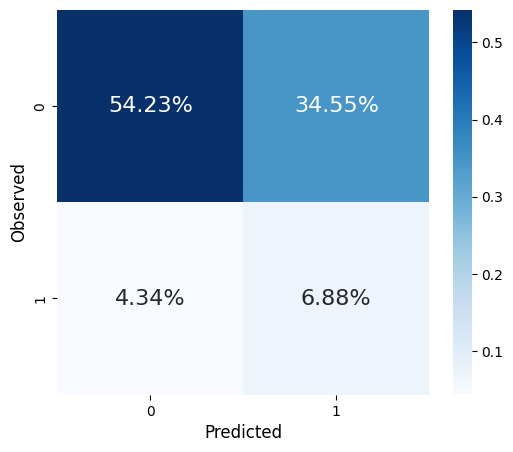

In [46]:
%matplotlib inline
clf = lgb.LGBMClassifier(random_state=rand, n_jobs=-1,\
                         **best_params)
clf.fit(X_train, y_train)

_, y_prob, y_pred = evaluate_class_mdl(clf, X_train, X_test, y_train, y_test)

In [47]:
X_orig_test['readmitted'].value_counts()

NO     16461
>30    10644
<30     3425
Name: readmitted, dtype: int64

In [48]:
preds_df = pd.DataFrame({'readmitted':X_orig_test['readmitted'],\
                         'y_true':y_test.astype(int),\
                         'y_pred':y_pred})
preds_df[(preds_df.y_true==0) & (preds_df.y_pred==1)].value_counts(normalize=True)

readmitted  y_true  y_pred
NO          0       1         0.502417
>30         0       1         0.497583
dtype: float64

In [49]:
def set_header_font():
    return [dict(selector="th", props=[("font-size", "14pt")])]

def metrics_by_group(s):
    accuracy = metrics.accuracy_score(s.y_true, s.y_pred) * 100
    precision = metrics.precision_score(s.y_true, s.y_pred) * 100
    recall = metrics.recall_score(s.y_true, s.y_pred) * 100
    f1 = metrics.f1_score(s.y_true, s.y_pred) * 100
    roc_auc, fnr, fpr = np.nan, np.nan, np.nan
    if len(np.unique(s.y_true)) == 2:
        roc_auc = metrics.roc_auc_score(s.y_true, s.y_prob) * 100
        tn, fp, fn, tp = metrics.confusion_matrix(s.y_true, s.y_pred).ravel()
        fnr = (fn/(tp+fn)) * 100
        fpr = (fp/(tn+fp)) * 100
    support = len(s.y_true)

    return pd.Series((support, accuracy, precision, recall, f1, roc_auc, fnr, fpr),\
                 index=['support', 'accuracy', 'precision', 'recall', 'f1', 'roc-auc', 'fnr', 'fpr'])

def error_breakdown_by_group(mdl, y_true, y_prob, y_pred, orig_df, group_col, exclude_groups=None):

    print(f"Error breakdown for group '{group_col}'")

    predict_df = pd.DataFrame({group_col: orig_df[group_col].tolist(),\
                              'y_true': y_true,
                              'y_pred': y_pred,
                              'y_prob': y_prob}, index=y_true.index)
    if exclude_groups is not None:
        predict_df = predict_df[~predict_df[group_col].isin(exclude_groups)]

    group_metrics_df = predict_df.groupby([group_col]).apply(metrics_by_group)

    html = group_metrics_df.sort_values(by='support', ascending=False).style.\
            format({'support':'{:,.0f}', 'accuracy':'{:.1f}%', 'precision':'{:.1f}%', 'recall':'{:.1f}%',\
                    'f1':'{:.1f}%', 'roc-auc':'{:.1f}%', 'fnr':'{:.1f}%', 'fpr':'{:.1f}%'}).\
            set_properties(**{'font-size': '13pt'}).set_table_styles(set_header_font()).\
            highlight_max(subset=['accuracy','precision','recall','f1','roc-auc']).\
            highlight_min(subset=['fnr','fpr'])

    return html

def compare_confusion_matrices(y_true_1, y_pred_1, y_true_2, y_pred_2, group_1, group_2,\
                               plot=True, compare_fpr=False):
    
    conf_matrix_1 = metrics.confusion_matrix(y_true_1, y_pred_1)
    conf_matrix_2 = metrics.confusion_matrix(y_true_2, y_pred_2)

    if plot:
        fig, ax = plt.subplots(1,2,figsize=(12,5))
        sns.heatmap(conf_matrix_1/np.sum(conf_matrix_1), annot=True,\
                    fmt='.2%', cmap='Blues', annot_kws={'size':16}, ax=ax[0])
        ax[0].set_title(group_1 + ' Confusion Matrix', fontsize=14)
        ax[0].set_xlabel('Predicted', fontsize=12)
        ax[0].set_ylabel('Observed', fontsize=12)
        sns.heatmap(conf_matrix_2/np.sum(conf_matrix_2), annot=True,\
                    fmt='.2%', cmap='Blues', annot_kws={'size':16}, ax=ax[1])
        ax[1].set_title(group_2 + ' Confusion Matrix', fontsize=14)
        ax[1].set_xlabel('Predicted', fontsize=12)
        ax[1].set_ylabel('Observed', fontsize=12)
        plt.show()

In [50]:
error_breakdown_by_group(clf, y_true=y_test, y_prob=y_prob, y_pred=y_pred, orig_df=X_orig_test, group_col='age')

Error breakdown for group 'age'


,support,accuracy,precision,recall,f1,roc-auc,fnr,fpr
age,,,,,,,,
Over 60 years,"20,566",57.7%,16.1%,61.1%,25.5%,62.5%,38.9%,42.8%
30-60 years,"9,201",67.6%,17.4%,61.1%,27.0%,68.4%,38.9%,31.7%
30 years or younger,763,74.0%,24.8%,69.5%,36.5%,77.3%,30.5%,25.4%


In [51]:
error_breakdown_by_group(clf, y_true=y_test, y_prob=y_prob, y_pred=y_pred, orig_df=X_orig_test, group_col='gender',\
                         exclude_groups=['Unknown/Invalid'])

Error breakdown for group 'gender'


,support,accuracy,precision,recall,f1,roc-auc,fnr,fpr
gender,,,,,,,,
Female,"16,448",59.8%,16.4%,62.0%,26.0%,64.7%,38.0%,40.4%
Male,"14,080",62.6%,16.8%,60.6%,26.4%,65.5%,39.4%,37.2%


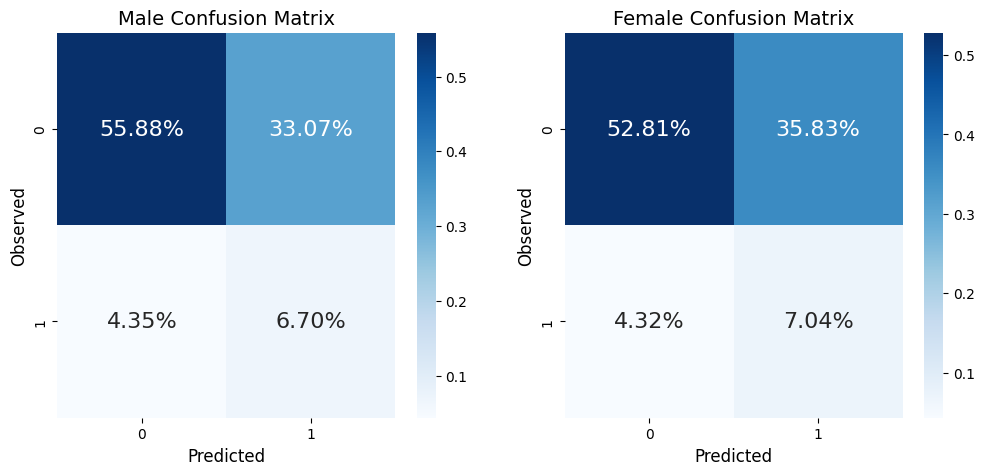

In [52]:
_ = compare_confusion_matrices(y_test[X_test['gender_Male']==1], y_pred[X_test['gender_Male']==1],\
                           y_test[X_test['gender_Female']==1], y_pred[X_test['gender_Female']==1],\
                           'Male', 'Female')

In [53]:
error_breakdown_by_group(clf, y_true=y_test, y_prob=y_prob, y_pred=y_pred, orig_df=X_orig_test, group_col='admission_source_id')

Error breakdown for group 'admission_source_id'


,support,accuracy,precision,recall,f1,roc-auc,fnr,fpr
admission_source_id,,,,,,,,
Emergency,"17,228",58.2%,16.9%,64.8%,26.8%,65.0%,35.2%,42.7%
Referral,"9,303",64.8%,16.7%,56.8%,25.8%,65.1%,43.2%,34.3%
Other,"3,999",65.2%,14.8%,54.8%,23.3%,64.0%,45.2%,33.7%


In [54]:
error_breakdown_by_group(clf, y_true=y_test, y_prob=y_prob, y_pred=y_pred, orig_df=X_orig_test, group_col='had_inpatient_days')

Error breakdown for group 'had_inpatient_days'


,support,accuracy,precision,recall,f1,roc-auc,fnr,fpr
had_inpatient_days,,,,,,,,
False,"20,292",79.2%,14.7%,30.3%,19.8%,62.6%,69.7%,16.2%
True,"10,238",25.2%,17.3%,92.6%,29.2%,57.6%,7.4%,88.3%


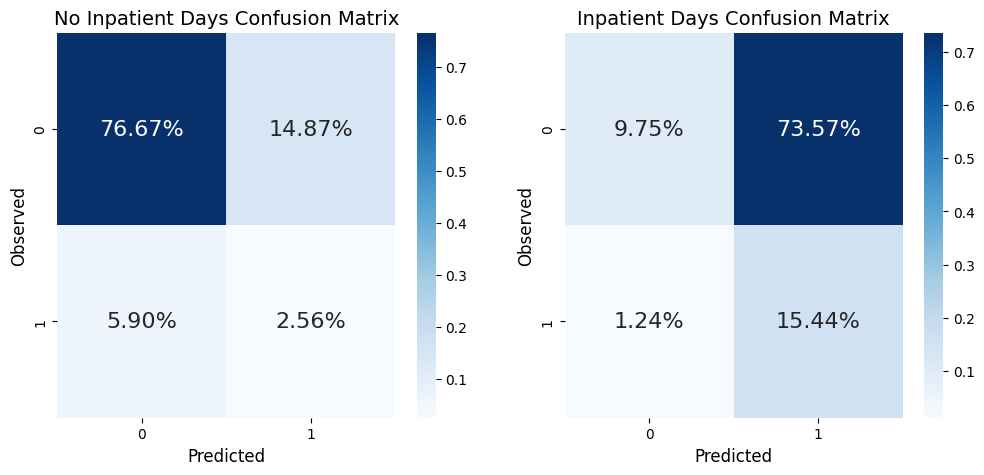

In [55]:
_ = compare_confusion_matrices(y_test[X_test['had_inpatient_days']==0], y_pred[X_test['had_inpatient_days']==0],\
                           y_test[X_test['had_inpatient_days']==1], y_pred[X_test['had_inpatient_days']==1],\
                           'No Inpatient Days', 'Inpatient Days', compare_fpr=True)

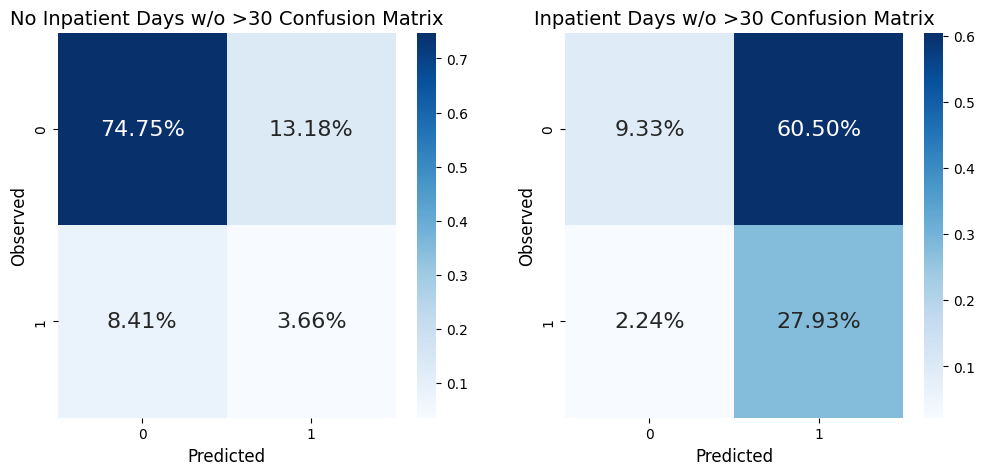

In [56]:
_ = compare_confusion_matrices(y_test[(X_test['had_inpatient_days']==0) & (X_orig_test['readmitted']!='>30')], y_pred[(X_test['had_inpatient_days']==0) & (X_orig_test['readmitted']!='>30')],\
                           y_test[(X_test['had_inpatient_days']==1) & (X_orig_test['readmitted']!='>30')], y_pred[(X_test['had_inpatient_days']==1) & (X_orig_test['readmitted']!='>30')],\
                           'No Inpatient Days w/o >30', 'Inpatient Days w/o >30', compare_fpr=True)

In [57]:
# Feature Importance and More Advanced Error Analysis

In [58]:
X_test_sample = X_test[(X_orig_test['readmitted']!='>30')].sample(frac=0.1)
y_test_sample = y_test.loc[X_test_sample.index]

y_prob_sample = clf.predict_proba(X_test_sample)[:,1]
y_pred_sample = np.where(y_prob_sample > 0.5, 1, 0)

In [59]:
X_test_sample

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_diagnoses,medicare,medicaid,had_emergency,had_inpatient_days,had_outpatient_days,race_AfricanAmerican,race_Asian,race_Caucasian,race_Hispanic,race_Other,race_Unknown,gender_Female,gender_Male,gender_Unknown/Invalid,age_30 years or younger,age_30-60 years,age_Over 60 years,discharge_disposition_id_Discharged to Home,discharge_disposition_id_Other,admission_source_id_Emergency,...,medical_specialty_Family/GeneralPractice,medical_specialty_InternalMedicine,medical_specialty_Missing,medical_specialty_Other,primary_diagnosis_Diabetes,primary_diagnosis_Genitourinary Issues,primary_diagnosis_Musculoskeletal Issues,primary_diagnosis_Other,primary_diagnosis_Respiratory Issues,max_glu_serum_>200,max_glu_serum_>300,max_glu_serum_None,max_glu_serum_Norm,A1Cresult_>7,A1Cresult_>8,A1Cresult_None,A1Cresult_Norm,insulin_Down,insulin_No,insulin_Steady,insulin_Up,change_Ch,change_No,diabetesMed_No,diabetesMed_Yes
20489,5,42,1,10,9,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,1,0,1,...,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,1
953,3,60,0,10,7,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,1,...,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,1
3714,13,75,6,28,9,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,1,1,...,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1
18373,5,41,2,20,9,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,1,...,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,1,0
50628,2,35,0,15,4,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,1,0,0,...,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52935,8,55,1,14,7,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,...,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,1
61979,3,47,0,9,5,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,1,0,0,...,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,1,0,0,1
81860,3,45,0,14,9,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,...,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,1
66276,3,62,0,17,7,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,1,0,...,0,0,1,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,1,0,0,1


In [60]:
%%time
shap_explainer = shap.Explainer(clf, X_train)
shap_values = shap_explainer(X_test_sample)

CPU times: total: 2.97 s
Wall time: 2.12 s


In [61]:
shap_values.values

array([[ 0.02608441,  0.04387763,  0.03314426, ...,  0.        ,
         0.01986546,  0.        ],
       [-0.00323803,  0.01059074,  0.01809974, ...,  0.00027396,
         0.01707283,  0.        ],
       [ 0.11071527, -0.14105878,  0.04244802, ...,  0.        ,
         0.05855201,  0.        ],
       ...,
       [-0.0123666 ,  0.0638717 ,  0.01628224, ...,  0.00027396,
         0.04912528,  0.        ],
       [-0.01350379,  0.15738295,  0.00084791, ...,  0.        ,
         0.05515351,  0.        ],
       [ 0.02708441, -0.02789334,  0.01205696, ...,  0.        ,
         0.02725172,  0.        ]])

In [63]:
print(shap_values.values.shape)

(1989, 54)


In [64]:
np.abs(shap_values.values).mean(axis=0)

array([6.16134277e-02, 5.76835690e-02, 3.07032375e-02, 5.35321768e-02,
       4.85629240e-02, 1.41491874e-02, 4.16841409e-04, 4.11076269e-02,
       2.79517525e-01, 5.10441809e-03, 7.35712077e-03, 1.80200950e-03,
       4.91669802e-03, 2.24258048e-03, 5.99790805e-03, 1.33695611e-02,
       3.18759989e-03, 8.24421795e-03, 0.00000000e+00, 3.75130446e-03,
       6.76928311e-04, 3.41525873e-02, 1.66277200e-01, 0.00000000e+00,
       5.09562688e-03, 1.77692372e-02, 1.58266259e-03, 1.20419676e-02,
       1.18645435e-02, 1.01741583e-02, 4.33205812e-03, 7.87519167e-03,
       4.25551613e-03, 1.53489106e-02, 1.60586183e-03, 1.14816959e-02,
       3.53341133e-02, 3.21987560e-02, 4.76041878e-04, 3.27100303e-04,
       4.96775157e-03, 6.80509304e-04, 5.57992267e-03, 3.96320090e-03,
       2.46365205e-02, 2.11725493e-03, 2.70980034e-02, 1.30737532e-02,
       2.47603134e-03, 4.91860526e-03, 6.84235273e-03, 1.67348474e-04,
       5.17936162e-02, 0.00000000e+00])

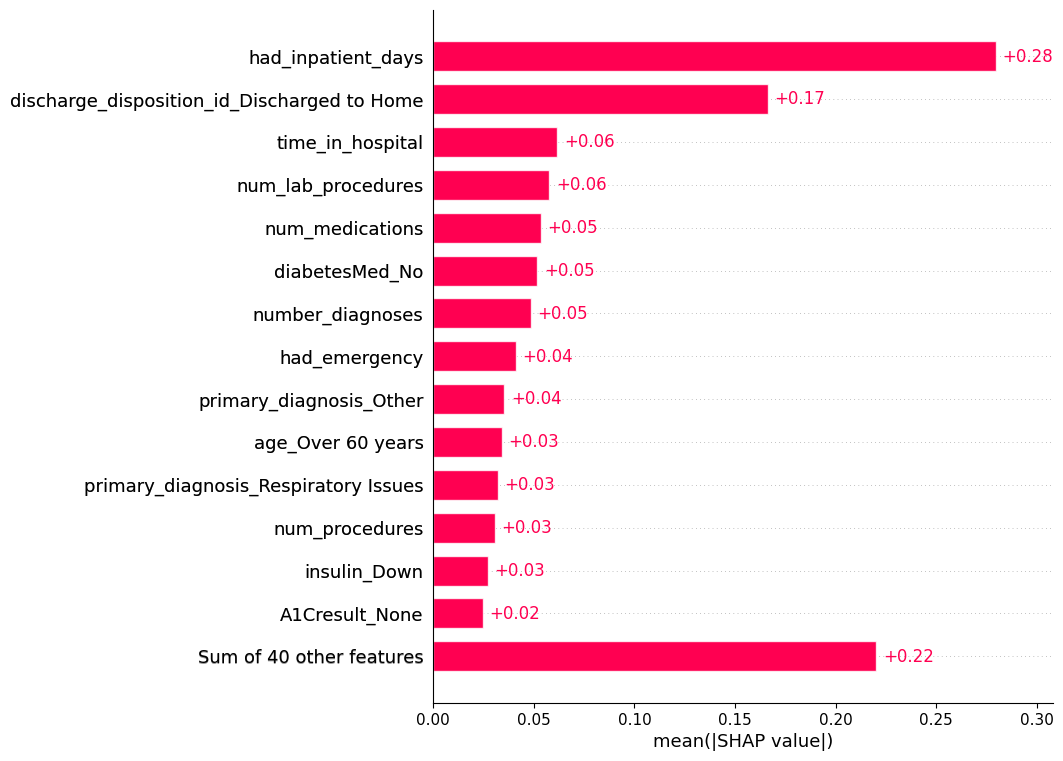

In [65]:
shap.plots.bar(shap_values, max_display=15)

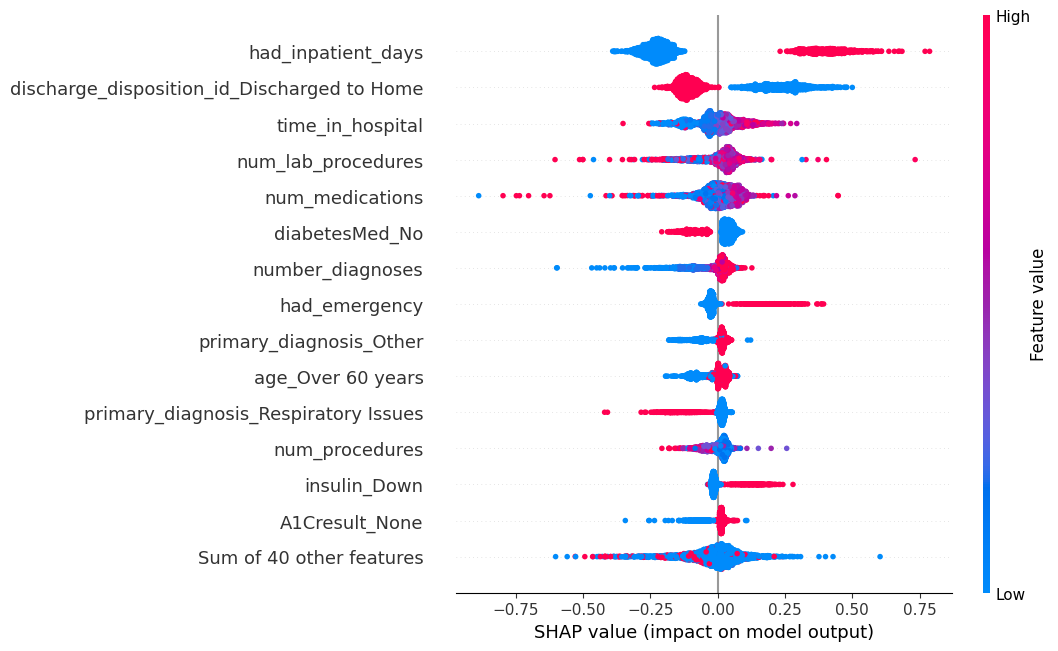

In [66]:
shap.plots.beeswarm(shap_values, max_display=15)

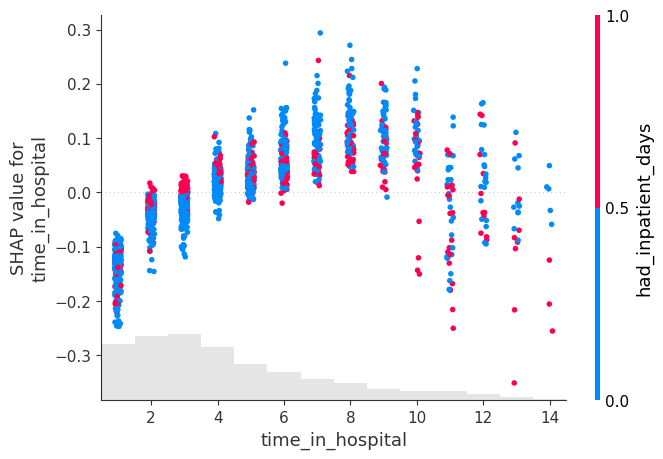

In [67]:
shap.plots.scatter(shap_values[:,"time_in_hospital"],\
                   color=shap_values[:,"had_inpatient_days"])

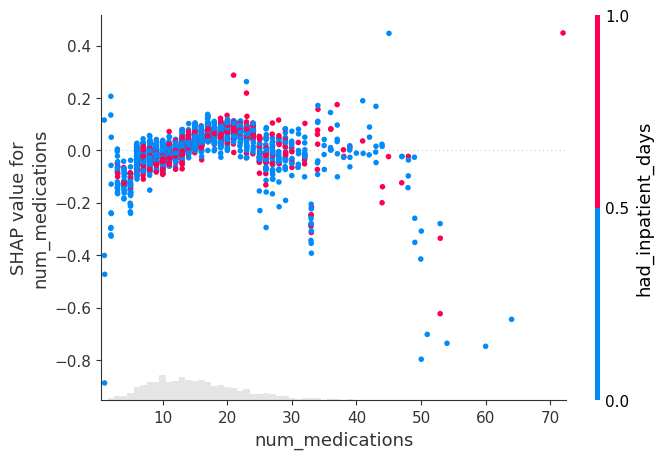

In [68]:
shap.plots.scatter(shap_values[:,"num_medications"],\
                   color=shap_values[:,"had_inpatient_days"])

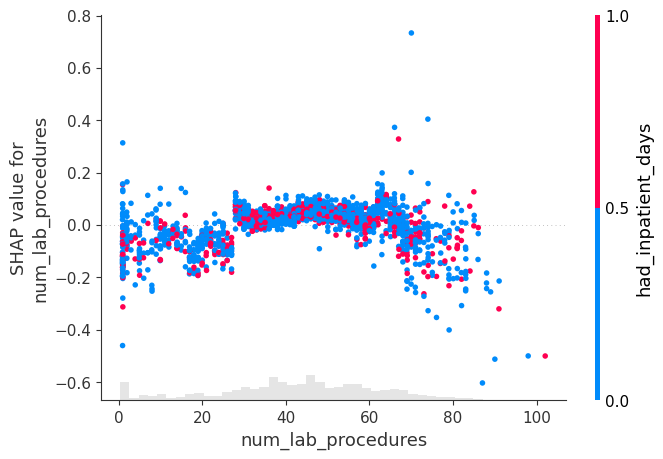

In [69]:
shap.plots.scatter(shap_values[:,"num_lab_procedures"],\
                   color=shap_values[:,"had_inpatient_days"])

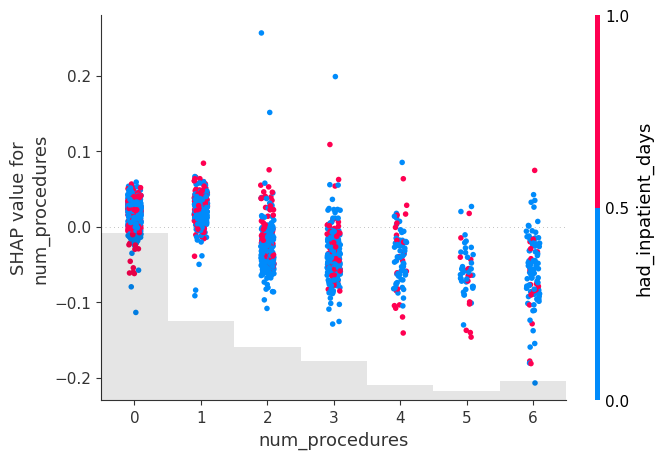

In [70]:
shap.plots.scatter(shap_values[:,"num_procedures"],\
                   color=shap_values[:,"had_inpatient_days"])

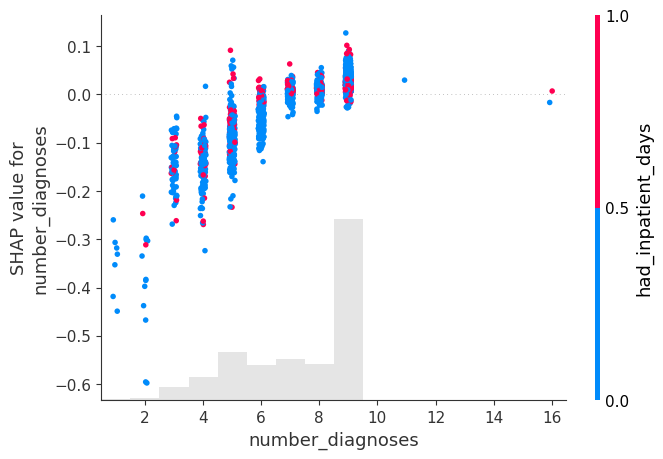

In [71]:
shap.plots.scatter(shap_values[:,"number_diagnoses"], color=shap_values[:,"had_inpatient_days"])

In [72]:
preds_df = pd.DataFrame({'readmitted':X_orig_test['readmitted'],\
                         'had_inpatient_days':X_test['had_inpatient_days'],\
                         'y_true':y_test.astype(int),\
                         'y_pred':y_pred,
                         'y_prob':y_prob})
preds_df = preds_df[(preds_df['readmitted']!='>30')]

preds_df['y_pred_new'] = np.where(preds_df.had_inpatient_days==0,\
                                  np.where(preds_df.y_prob > 0.45, 1, 0),
                                  np.where(preds_df.y_prob > 0.59, 1, 0))

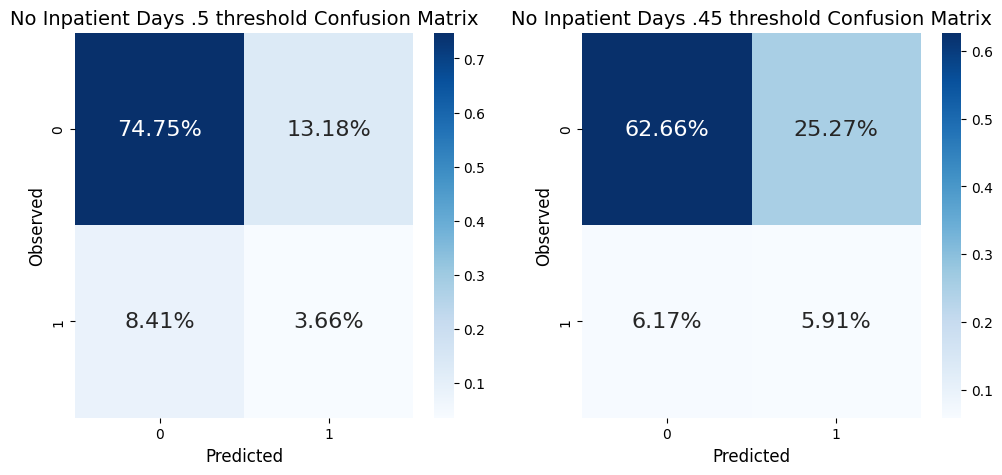

In [73]:
_ = compare_confusion_matrices(preds_df.loc[preds_df.had_inpatient_days==0, 'y_true'],\
                               preds_df.loc[preds_df.had_inpatient_days==0, 'y_pred'],\
                               preds_df.loc[preds_df.had_inpatient_days==0, 'y_true'],
                               preds_df.loc[preds_df.had_inpatient_days==0, 'y_pred_new'],
                               'No Inpatient Days .5 threshold', 'No Inpatient Days .45 threshold')

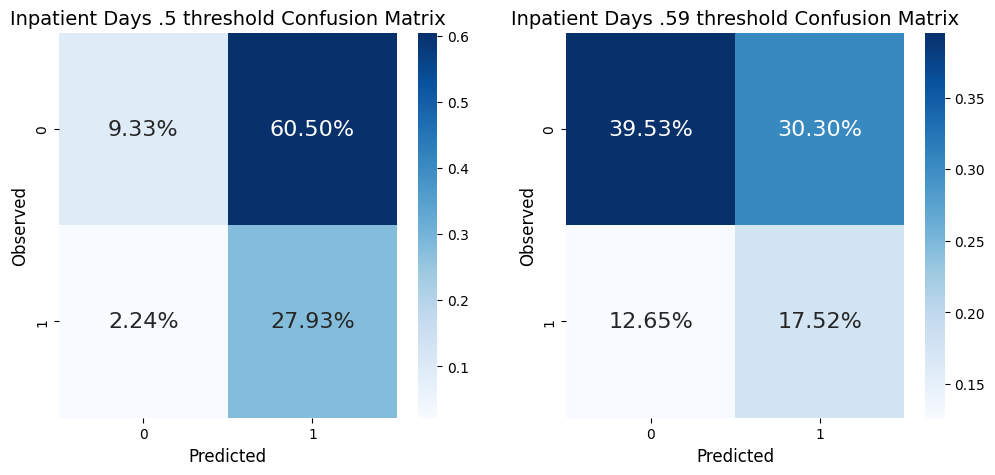

In [74]:
_ = compare_confusion_matrices(preds_df.loc[preds_df.had_inpatient_days==1, 'y_true'],\
                               preds_df.loc[preds_df.had_inpatient_days==1, 'y_pred'],\
                               preds_df.loc[preds_df.had_inpatient_days==1, 'y_true'],
                               preds_df.loc[preds_df.had_inpatient_days==1, 'y_pred_new'],
                               'Inpatient Days .5 threshold', 'Inpatient Days .59 threshold')